```markdown
# Building a Recurrent Neural Network (RNN) for Sentiment Analysis

Get ready to dive into the world of deep learning as we build a powerful RNN to analyze sentiments!
```

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy

In [2]:
# Load dataset
url = "https://raw.githubusercontent.com/justmarkham/DAT8/master/data/sms.tsv"
df = pd.read_csv(url, delimiter='\t', header=None, names=['label', 'text'])

In [3]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df['label']

,label
0,ham
1,ham
2,spam
3,ham
4,ham
...,...
5567,spam
5568,ham
5569,ham
5570,ham


In [5]:
df['text'] = df['text'].str.lower()

In [6]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [7]:
punc = "#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
def remove_punc(text):
  for char in punc:
    text = text.replace(char,'')
  return text

text = "hello. hru. kya?"
remove_punc(text)

'hello hru kya'

In [8]:
df['text'] = df['text'].apply(remove_punc)
df.head()

,label,text
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...


In [9]:
# another punc remove function which takes less time
def remove_punc1(text):
  return text.translate(str.maketrans('','',punc))



> you can use textBlob to correct the spellings



In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
from nltk import word_tokenize

In [12]:
text = "chirag! hu me"
word_tokenize(text)

['chirag', '!', 'hu', 'me']

In [13]:
df['text'] = df['text'].apply(word_tokenize)
df.head()

,label,text
0,ham,"[go, until, jurong, point, crazy, available, o..."
1,ham,"[ok, lar, joking, wif, u, oni]"
2,spam,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,"[nah, i, dont, think, he, goes, to, usf, he, l..."


In [14]:
df['text'][0]

['go',
 'until',
 'jurong',
 'point',
 'crazy',
 'available',
 'only',
 'in',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'there',
 'got',
 'amore',
 'wat']

In [88]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

In [89]:
from sklearn.model_selection import train_test_split

In [90]:
train_data, test_data = train_test_split(df,train_size=0.8,test_size=0.2)

In [91]:
len(train_data),len(test_data)

(4457, 1115)

In [93]:
len(vocab)

9608

In [130]:
vocab = set([word for phrase in df['text'] for word in phrase])
word_to_idx = {word: idx for idx, word in enumerate(vocab, 1)}

#stoi = {s:i for i,s in enumerate(vocab,1)}

In [133]:
def encode_phrase(phrase):
    return [word_to_idx.get(word, 0) for word in phrase]  # Use 0 or a special index for unknown words


In [134]:
train_data['text'] = train_data['text'].apply(encode_phrase)
test_data['text'] = test_data['text'].apply(encode_phrase)

In [135]:
max_length = max(df['text'].apply(len))

def pad_sequence(seq, max_length):
    return seq + [0] * (max_length - len(seq))

In [136]:
train_data['text'] = train_data['text'].apply(lambda x: pad_sequence(x, max_length))
test_data['text'] = test_data['text'].apply(lambda x: pad_sequence(x, max_length))

In [137]:
# vocab = set([word for phrase in df['text'] for word in phrase])
# word_to_idx = {word: idx for idx, word in enumerate(vocab, 1)}

# def encode_phrase(phrase):
#     return [stoi[word] for word in phrase]

# train_data['text'] = train_data['text'].apply(encode_phrase)
# test_data['text'] = test_data['text'].apply(encode_phrase)

# # Padding sequences
# max_length = max(df['text'].apply(len))

# def pad_sequence(seq, max_length):
#     return seq + [0] * (max_length - len(seq))

# train_data['text'] = train_data['text'].apply(lambda x: pad_sequence(x, max_length))
# test_data['text'] = test_data['text'].apply(lambda x: pad_sequence(x, max_length))

In [138]:

from torch.utils.data import Dataset, DataLoader

class SentimentDataset(Dataset):
    def __init__(self, data):
        self.texts = data['text'].values
        self.labels = data['label'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Get the text and label
        text = self.texts[idx]
        label = self.labels[idx]

        # Convert text to tensor directly since it's already padded
        text_tensor = torch.tensor(text, dtype=torch.long)

        # Ensure label is a single integer
        label_tensor = torch.tensor(int(label), dtype=torch.long)

        return text_tensor, label_tensor

# Usage
train_dataset = SentimentDataset(train_data)
test_dataset = SentimentDataset(test_data)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [139]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

vocab_size = len(vocab) + 1
embed_size = 128
hidden_size = 128
output_size = 2  # For binary classification
model = SentimentRNN(vocab_size, embed_size, hidden_size, output_size)



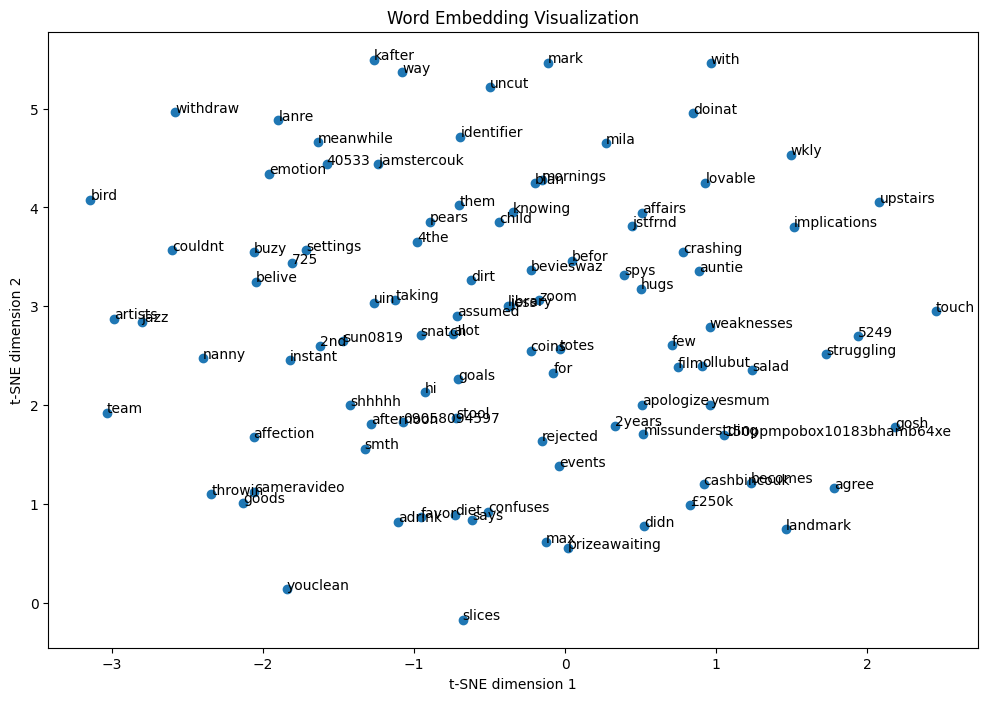

In [140]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(model, vocab, num_words=100):
    # Get the embedding layer
    embedding_layer = model.embedding

    # Get the embedding weights
    embeddings = embedding_layer.weight.data.cpu().numpy()

    # Select a subset of words to visualize (e.g., the first 100 words)
    words = list(vocab.keys())[:num_words]
    word_embeddings = embeddings[:num_words]

    # Perform t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(word_embeddings)

    # Create a scatter plot
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

    # Add word labels to the plot
    for i, word in enumerate(words):
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]))

    plt.title("Word Embedding Visualization")
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.show()

# Call the function to visualize embeddings
visualize_embeddings(model, stoi)

In [141]:
loss_fn = nn.CrossEntropyLoss()

In [142]:
optimizer = torch.optim.SGD(model.parameters(),0.01)

In [147]:
train_losses = []
test_losses = []
epochs = 10

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    # Training loop
    for texts, labels in train_loader:
        out = model(texts)
        loss = loss_fn(out, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Evaluation loop
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for textss, labelss in test_loader:
            test_pred = model(textss)

            loss = loss_fn(test_pred, labelss)
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))
    print(f"epoch: {epoch + 1} | train_loss: {epoch_loss / len(train_loader):.4f} | test_loss: {test_loss / len(test_loader):.4f}")


epoch: 1 | train_loss: 0.3967 | test_loss: 0.3921
epoch: 2 | train_loss: 0.3958 | test_loss: 0.3928
epoch: 3 | train_loss: 0.3952 | test_loss: 0.3924
epoch: 4 | train_loss: 0.3960 | test_loss: 0.3929
epoch: 5 | train_loss: 0.3942 | test_loss: 0.3922
epoch: 6 | train_loss: 0.3982 | test_loss: 0.3971
epoch: 7 | train_loss: 0.3957 | test_loss: 0.3920
epoch: 8 | train_loss: 0.3953 | test_loss: 0.3920
epoch: 9 | train_loss: 0.3946 | test_loss: 0.3928
epoch: 10 | train_loss: 0.3953 | test_loss: 0.3932


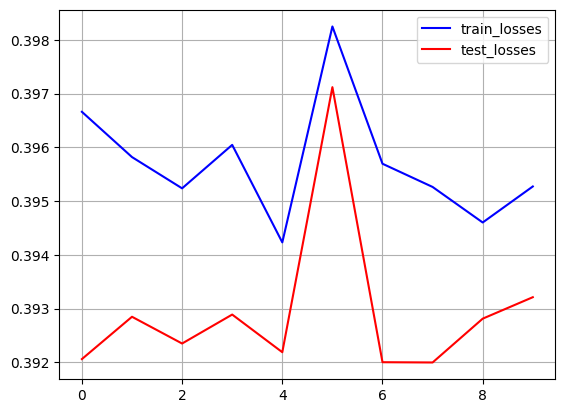

In [152]:
plt.figure()
plt.plot(train_losses,'b')
plt.plot(test_losses,'r')
plt.legend(['train_losses','test_losses'])
plt.grid(True)
plt.show()

In [153]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')


Accuracy: 86.73%
